# Econometric Methods in Python
### by [Jason DeBacker](http://jasondebacker.com), October 2021

This notebook illustrates some of the econometric tools available in Python by estimating OLS and IV models.

To illustrate OLS and IV estimators, we'll use some example data from an econometic textbook.  We'll take an example dataset from the book by Christian Kleiber and Achim Zeileis (2008).

In [1]:
 # import Python packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm
from stargazer.stargazer import Stargazer

In [2]:
# Read in 1976 PSID data from csv file
PSID1976 = pd.read_csv('PSID1976.csv')

 # OLS and IV

We'll look at the implementation of OLS and IV estimators by estimating models of female labor supply.  We'll do this with data on married women from the 1976 PSID.  This example comes from [this](https://www.r-bloggers.com/instrumental-variables-in-r-exercises-part-3/) exercise from R-bloggers.

In [3]:
## Load data from the 1976 PSID and look at first 5 rows
PSID1976.head()

,Unnamed: 0,participation,hours,youngkids,oldkids,age,education,wage,repwage,hhours,...,hwage,fincome,tax,meducation,feducation,unemp,city,experience,college,hcollege
0,1,yes,1610,1,0,32,12,3.3540,2.65,2708,...,4.0288,16310,0.7215,12,7,5.0,no,14,no,no
1,2,yes,1656,0,2,30,12,1.3889,2.65,2310,...,8.4416,21800,0.6615,7,7,11.0,yes,5,no,no
2,3,yes,1980,1,3,35,12,4.5455,4.04,3072,...,3.5807,21040,0.6915,12,7,5.0,no,15,no,no
3,4,yes,456,0,3,34,12,1.0965,3.25,1920,...,3.5417,7300,0.7815,7,7,5.0,no,6,no,no
4,5,yes,1568,1,2,31,14,4.5918,3.60,2000,...,10.0000,27300,0.6215,12,14,9.5,yes,7,yes,no


In [4]:
PSID1976.describe()

,Unnamed: 0,hours,youngkids,oldkids,age,education,wage,repwage,hhours,hage,heducation,hwage,fincome,tax,meducation,feducation,unemp,experience
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.00000
mean,377.000000,740.576361,0.237716,1.353254,42.537849,12.286853,2.374565,1.849734,2267.270916,45.120850,12.491368,7.482179,23080.594954,0.678863,9.250996,8.808765,8.623506,10.63081
std,217.516666,871.314216,0.523959,1.319874,8.072574,2.280246,3.241829,2.419887,595.566649,8.058793,3.020804,4.230559,12190.202026,0.083496,3.367468,3.572290,3.114934,8.06913
min,1.000000,0.000000,0.000000,0.000000,30.000000,5.000000,0.000000,0.000000,175.000000,30.000000,3.000000,0.412100,1500.000000,0.441500,0.000000,0.000000,3.000000,0.00000
25%,189.000000,0.000000,0.000000,0.000000,36.000000,12.000000,0.000000,0.000000,1928.000000,38.000000,11.000000,4.788300,15428.000000,0.621500,7.000000,7.000000,7.500000,4.00000
50%,377.000000,288.000000,0.000000,1.000000,43.000000,12.000000,1.625000,0.000000,2164.000000,46.000000,12.000000,6.975800,20880.000000,0.691500,10.000000,7.000000,7.500000,9.00000
75%,565.000000,1516.000000,0.000000,2.000000,49.000000,13.000000,3.787900,3.580000,2553.000000,52.000000,15.000000,9.166700,28200.000000,0.721500,12.000000,12.000000,11.000000,15.00000
max,753.000000,4950.000000,3.000000,8.000000,60.000000,17.000000,25.000000,9.980000,5010.000000,60.000000,17.000000,40.509000,96000.000000,0.941500,17.000000,17.000000,14.000000,45.00000


In [5]:
# Get a list of all column names
PSID1976.keys()

Index(['Unnamed: 0', 'participation', 'hours', 'youngkids', 'oldkids', 'age',
       'education', 'wage', 'repwage', 'hhours', 'hage', 'heducation', 'hwage',
       'fincome', 'tax', 'meducation', 'feducation', 'unemp', 'city',
       'experience', 'college', 'hcollege'],
      dtype='object')

We'll be looking at female labor supply of married women, so let's define a dataset that is just married women who are in the labor force.

In [6]:
# Subset data to just get those participating in the labor force
df = PSID1976[PSID1976.participation == "yes"]
df.describe()

,Unnamed: 0,hours,youngkids,oldkids,age,education,wage,repwage,hhours,hage,heducation,hwage,fincome,tax,meducation,feducation,unemp,experience
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,214.500000,1302.929907,0.140187,1.350467,41.971963,12.658879,4.177682,3.185864,2233.464953,44.609813,12.612150,7.226226,24130.422897,0.668333,9.516355,8.988318,8.545561,13.037383
std,123.697211,776.274385,0.391923,1.315935,7.721084,2.285376,3.310282,2.439640,582.908769,7.950055,3.035163,3.571217,11671.255986,0.076936,3.308100,3.523405,3.033328,8.055923
min,1.000000,12.000000,0.000000,0.000000,30.000000,5.000000,0.128200,0.000000,175.000000,30.000000,4.000000,0.512800,2400.000000,0.441500,0.000000,0.000000,3.000000,0.000000
25%,107.750000,609.500000,0.000000,0.000000,35.000000,12.000000,2.262600,1.420000,1920.000000,38.000000,11.000000,4.821750,16286.250000,0.621500,7.000000,7.000000,7.500000,7.000000
50%,214.500000,1365.500000,0.000000,1.000000,42.000000,12.000000,3.481900,3.195000,2106.500000,45.000000,12.000000,6.683100,21961.000000,0.691500,10.000000,7.000000,7.500000,12.000000
75%,321.250000,1910.500000,0.000000,2.000000,47.250000,14.000000,4.970750,4.550000,2504.000000,51.000000,16.000000,8.837775,29793.000000,0.721500,12.000000,12.000000,11.000000,18.000000
max,428.000000,4950.000000,2.000000,8.000000,60.000000,17.000000,25.000000,9.980000,5010.000000,60.000000,17.000000,26.578000,91044.000000,0.941500,17.000000,17.000000,14.000000,38.000000


## OLS

We start with a simple OLS model estimating the impact of education and experience on log wages:

$$ ln(wage_{i}) = \alpha + \beta_{1} education_i + \beta_{2}experience_{i} + \beta_{3} experience^{2}_{i} + \varepsilon_i $$

To estimate an OLS model in Python, use the [`statsmodels.formula.api`](https://www.statsmodels.org/stable/regression.html) module.

In [7]:
# Define the model
wage_OLS = smf.ols(formula='np.log(wage) ~ education + experience + np.power(experience, 2)', data=df)
# Estimate the model
res = wage_OLS.fit()
# Show the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     26.29
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           1.30e-15
Time:                        10:17:01   Log-Likelihood:                -431.60
No. Observations:                 428   AIC:                             871.2
Df Residuals:                     424   BIC:                             887.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [8]:
# look into the OLS Results object
dir(res)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initia

In [13]:
# grab the parameters
res.params

Intercept                 -0.522041
education                  0.107490
experience                 0.041567
np.power(experience, 2)   -0.000811
dtype: float64

In [15]:
# run an f-test
hypotheses = '(education = 0), (experience = 0)'
res.f_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[35.42844987]]), p=5.913982638501025e-15, df_denom=424, df_num=2>

In [16]:
# Or just get the f statistic/p-value for the test that all coeffs diff from zero
res.f_pvalue

1.3017661888741576e-15

If you wanted to adjust the standard errors (e.g., clutered, robust, etc), you can do that by changing a keyword arugment in the `fit` method that allows you to set the variance-covariance matrix used for the standard errors.  With this, we'll call the heteroskedastic robust VCV matrix function `HC1`.

We won't use robust standard errors for these exercises, but to illustrate how this is done, suppose that we want robust standard errors for the model above.

In [17]:
# Compute robust standard errors using the HC1 method (same as Stata with "robust" option)
# Estimate the model
res = wage_OLS.fit(cov_type='HC1')
# Show the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     27.30
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           3.68e-16
Time:                        10:22:26   Log-Likelihood:                -431.60
No. Observations:                 428   AIC:                             871.2
Df Residuals:                     424   BIC:                             887.4
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

We can also estimate the linear model via a GMM estimator.  We should get the same coefficients, but the standard errors are computed differently.

In [18]:
wage_GMM = lm.IVGMM.from_formula(
    'np.log(wage) ~ 1 + experience + np.power(experience, 2) + education',
    df)
# Estimate the model
gmm_results = wage_GMM.fit()
# Show the results
print(gmm_results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:           np.log(wage)   R-squared:                      0.1568
Estimator:                     IV-GMM   Adj. R-squared:                 0.1509
No. Observations:                 428   F-statistic:                    82.671
Date:                Tue, Oct 12 2021   P-value (F-stat)                0.0000
Time:                        10:23:21   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                  -0.5220     0.2007    -2.6010     0.0093     -0.9154     -0.1287


/Users/jason.debacker/anaconda3/lib/python3.7/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


## Plotting regression results

There are plotting capabilities built into the `statsmodels` objects.  Here, we'll illustrate one, a plot of fitted values.


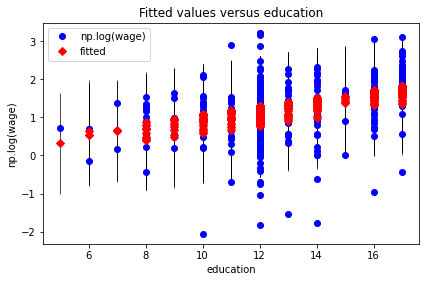

In [19]:
fig = sm.graphics.plot_fit(res, "education")
fig.tight_layout(pad=1.0)

In [20]:
# save figure to disk
fig.savefig('fitted_values.png')

# Instrumental Variables Regression Models


## IV via 2SLS

Of course estimates to the returns to education in the model above are likely biased since education and wages are likely correlated with other factors we aren't (or can't) control for such as cognitive and non-cognitive abilities that make one more productive in school and on the job.

To reduce the bias that results from this ommited variable, let's estimate an instrumental variables (IV) model.  Here, we'll argue that the education of the woman's father is correlated with her education level, but not her wages (conditional on her education and experience).  Thus father's education can help provide exogenous variation in education (conditional on father's education and other covariates).

One approach to IV models is to use the two-stage least squares (2SLS) estimator, where a model of the woman's eduation is estimated in a first stage:

$$ education_{i} = \gamma_{0} + \gamma_{1}father\_education_{i} + \gamma_{2}experience_{i} + \gamma_{3} experience^{2}_{i} + u_i $$

And then the predicted values of the the woman's education are used in the second stage to estimate the returns to education:


$$ ln(wage_{i}) = \alpha + \beta_{1} \hat{education}_i + \beta_{2}experience_{i} + \beta_{3} experience^{2}_{i} + \varepsilon_i $$

In this way, we ensure that the error term is uncorrelated with the covariates in the second stage.

To estimate this model via 2SLS, we'll use the [`linearmodels.IV2SLS1`](https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html#2SLS-as-OLS) function.

In [21]:
# Call the IV2SLS function.
wage_IV = lm.IV2SLS.from_formula(
    'np.log(wage) ~ 1 + experience + np.power(experience, 2) + [education ~ feducation]',
    df)
# Estimate the model
iv_results = wage_IV.fit()
# Show the results
print(iv_results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           np.log(wage)   R-squared:                      0.1430
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1370
No. Observations:                 428   F-statistic:                    19.229
Date:                Tue, Oct 12 2021   P-value (F-stat)                0.0002
Time:                        10:26:17   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                  -0.0611     0.4560    -0.1340     0.8934     -0.9548      0.8326


/Users/jason.debacker/anaconda3/lib/python3.7/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


## Testing for endogeneity

A standard test to run for IV models is the Hausman test for edogeneity fo the suspected endogenous variable.  This and other tests are available as attributes of the `IV2LS` results object.  We can peer into `iv_results`, which is an instance of this object to see what is available.  We can get a list of the attributes and methods the object has with the `dir()` function: 

In [22]:
# Look into the IV Results object
dir(iv_results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cov',
 '_cov_config',
 '_cov_estimator',
 '_cov_type',
 '_datetime',
 '_debiased',
 '_df_model',
 '_endogeneity_setup',
 '_f_statistic',
 '_fitted',
 '_kappa',
 '_liml_kappa',
 '_method',
 '_original_index',
 '_out_of_sample',
 '_params',
 '_r2',
 '_repr_html_',
 '_resid',
 '_rss',
 '_s2',
 '_top_right',
 '_tss',
 '_update_extra_text',
 '_vars',
 '_wresid',
 'anderson_rubin',
 'basmann',
 'basmann_f',
 'conf_int',
 'cov',
 'cov_config',
 'cov_estimator',
 'cov_type',
 'debiased',
 'df_model',
 'df_resid',
 'durbin',
 'f_statistic',
 'first_stage',
 'fitted_values',
 'has_constant',
 'idiosyncratic',
 'kappa',
 'method',

We can see a number of test statistics and other results are attributes.  Let's look at the first-stage regression results:

In [23]:
print(iv_results.first_stage.summary)

    First Stage Estimation Results    
                             education
--------------------------------------
R-squared                       0.1755
Partial R-squared               0.1715
Shea's R-squared                0.1715
Partial F-statistic             87.591
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       9.8870
                              (26.424)
experience                      0.0468
                              (1.0983)
np.power(experience, 2)        -0.0012
                             (-0.8532)
feducation                      0.2705
                              (9.3590)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


And now the Wu-Hausman test statistic:

In [24]:
print(iv_results.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1.4373
P-value: 0.2312
Distributed: F(1,423)


Here, we see that the Wu-Hausman test finds that we can't reject the null hypothesis that OLS is consistent - at least at standard levels of significance.

## IV via GMM

We can also estimate this instrumental variables model via GMM.  The GMM estimator has the following $K$ moment conditions (where $K$ are the number of instruments in $z_{i}$):

$$ g(\beta_{0}) = E[z_{i}\varepsilon_{i}] = E[z_{i}(y_{i}-x_{i}^{'}\beta_{0}] = 0 $$

Where $z_{i}$ is the instrument set (e.g., in the example here, $z_{i}$ = a constant, fathers's education, experience, and experience squared (and thus $K=4$).

To use this estimator, we'll call the [`linearmodels.IVGMM`](https://bashtage.github.io/linearmodels/doc/iv/methods.html#linearmodels.iv.model.IVGMM) function.

In [25]:
# Call the IVGMM function
wage_GMM_IV = lm.IVGMM.from_formula(
    'np.log(wage) ~ 1 + experience + np.power(experience, 2) + [education ~ feducation]',
    df)
# Estimate the model
iv_gmm_results = wage_GMM_IV.fit()
# Show the results
print(iv_gmm_results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:           np.log(wage)   R-squared:                      0.1430
Estimator:                     IV-GMM   Adj. R-squared:                 0.1370
No. Observations:                 428   F-statistic:                    19.229
Date:                Tue, Oct 12 2021   P-value (F-stat)                0.0002
Time:                        10:28:50   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                  -0.0611     0.4560    -0.1340     0.8934     -0.9548      0.8326


As we'd expect, GMM returns the same point estimats, but different S.E.'s than 2SLS.

Now let's estimate an overidentified model.  When we do this, we can do some overidentification tests (e.g. to see that our excluded instruments are exogenous).  We have one potentially endogenous regressor, education.  If we add one more instrument, we will have an over-identified model.  Let's now use mother's education in addition to father's education in the set of excluded instruments.  And let's estimate this model via 2SLS.

In [26]:
# Call the IV2SLS function.
wage_IV = lm.IV2SLS.from_formula(
    'np.log(wage) ~ 1 + experience + np.power(experience, 2) + [education ~ feducation + meducation]',
    df)
# Estimate the model
iv_results = wage_IV.fit()
# Show the results
print(iv_results.summary)
# Show the results of the Sargan over-idenfitication test
print(iv_results.sargan)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           np.log(wage)   R-squared:                      0.1357
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1296
No. Observations:                 428   F-statistic:                    18.611
Date:                Tue, Oct 12 2021   P-value (F-stat)                0.0003
Time:                        10:29:36   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   0.0481     0.4278     0.1124     0.9105     -0.7903      0.8865


The Sargan J-Stat has a p-value of 0.5386 meaning that we can't reject the null that the excluded instruments are exogenous (at least at standard levels of significance).

## Printing regression output for external use

You will want to save model output you are interested in using in a paper/presentation into a format that can easily be put into nicely formated tables.  These tables may be in Excel or LaTeX or something else.  My preferred method has been to:
1. Save output from models into text files that are linked to in an Excel workbook
2. Have a worksheet in this workbook that reads the raw output from the models and another worksheet that formats the output for presentation (again, linking to the raw output worksheet so not manual manipulation needs to be done after this is initially set up).
3. I then use Excel2Latex to create the TeX code that reproduces this table.
4. The TeX code is pasted into my TeX document (usually requiring a few adjustments).

This may not be the most efficient method, but Excel gives a nice view of the results without having to compile TeX or scroll through a pdf) and there often needs to be some adjustment of variables names etc. to properly size tables and the intermediate step of using Excel can be helpful here.

In any case, I show how to output the model results as both TeX code and a text file (for importing into Excel) below.

Note that relative to what we did with `R`, Python has less developed packages for automatically formatting output in the standard way economists present regression results (e.g., columns for each model, standard errors under point estimates).   On the othe hand, Python offers lots of flexiblity and it's relatively straightfoward to build your own custom formatted table.

## Tables from model results

First, note that the `summary` method of the `Results` object from these models has a method to return an ACSII text string or string with the LaTex code for the table: 

In [29]:
print(iv_results.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &    np.log(wage)    & \textbf{  R-squared:         } &      0.1357      \\
\textbf{Estimator:}              &      IV-2SLS       & \textbf{  Adj. R-squared:    } &      0.1296      \\
\textbf{No. Observations:}       &        428         & \textbf{  F-statistic:       } &      18.611      \\
\textbf{Date:}                   &  Tue, Oct 12 2021  & \textbf{  P-value (F-stat)   } &      0.0003      \\
\textbf{Time:}                   &      10:29:36      & \textbf{  Distribution:      } &     chi2(3)      \\
\textbf{Cov. Estimator:}         &       robust       & \textbf{                     } &                  \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                 & \textbf{Parameter} & \textbf{Std. Err.} & \textbf{T-stat} & \textbf{P-value} & \textbf{Lower CI} & \textbf{Upper CI}  \\
\midrule
\textbf{Intercept}               &       0.0481       &       0.4278       &      0.

In addition, for regression models done in the `statsmodels` package, there is a `summary_col` function that allows one to print multiple modles together in a table that is somewhat similar to what is output from the Stata `outreg` command:

In [47]:
# make TeX table of wage_IV2 model
from statsmodels.iolib.summary2 import summary_col
# summar_col only works with the statsmodels results - not linearmodels
res3 = summary_col([res, res],model_names=['Model 1', 'Model 2'], stars=False, float_format='%0.4f',
              info_dict={'R2':lambda x: "{:.4f}".format(x.rsquared)})
print(res3.as_latex())  # can to as_text or as_html also

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                        & Model 1  & Model 2   \\
\hline
Intercept               & -0.5220  & -0.5220   \\
                        & (0.2017) & (0.2017)  \\
education               & 0.1075   & 0.1075    \\
                        & (0.0132) & (0.0132)  \\
experience              & 0.0416   & 0.0416    \\
                        & (0.0153) & (0.0153)  \\
np.power(experience, 2) & -0.0008  & -0.0008   \\
                        & (0.0004) & (0.0004)  \\
R-squared               & 0.1568   & 0.1568    \\
R-squared Adj.          & 0.1509   & 0.1509    \\
R2                      & 0.1568   & 0.1568    \\
\hline
\end{tabular}
\end{center}
\end{table}


In [48]:
# save to file
tex_str = res3.as_latex()
with open('IVresults.tex', 'w+') as fh:
    fh.write(tex_str)

There is a `Stargazer` package for python that is similar with the `R` library with the same name, although the Python package is less developed.

Finally, it's straightforward to pull parameters, standard errors, etc out of the results objects and to place these in a dictionary, which can then put used to create a Latex (or text or html, etc) table.

In [44]:
df[['hours', 'age', 'wage', 'education']].describe().to_latex('summ_stats.tex')

# References
Christian Kleiber and Achim Zeileis (2008), *Applied Econometrics with R*, Springer-Verlag, New York.
ISBN 978-0-387-77316-2.